# Gaussian Processes for Vector Fields and Ocean Current Modelling

In this notebook, we use Gaussian processes to learn vector-valued functions. We will be
recreating the results by [Berlinghieri et al. (2023)](https://arxiv.org/pdf/2302.10364.pdf) by an
application to real-world ocean surface velocity data, collected via surface drifters.

Surface drifters are measurement devices that measure the dynamics and circulation patterns of the world's oceans. Studying and predicting ocean currents are important to climate research, for example, forecasting and predicting oil spills, oceanographic surveying of eddies and upwelling, or providing information on the distribution of biomass in ecosystems. We will be using the [Gulf Drifters Open dataset](https://zenodo.org/record/4421585), which contains all publicly available surface drifter trajectories from the Gulf of Mexico spanning 28 years.

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import hessian
from jax.config import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from matplotlib import rcParams
import matplotlib.pyplot as plt
import jaxopt
import pandas as pd
import tensorflow_probability as tfp
import optax as ox
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data loading and preprocessing
The real dataset has been binned into an $N=34\times16$ grid, equally spaced over the longitude-latitude interval $[-90.8,-83.8] \times [24.0,27.5]$. Each bin has a size $\approx 0.21\times0.21$, and contains the average velocity across all measurements that fall inside it.

We will call this binned ocean data the ground truth, and label it with the vector field
$$
\mathbf{F} \equiv \mathbf{F}(\mathbf{x}),
$$
where $\mathbf{x} = (x^{(0)}$,$x^{(1)})^\text{T}$, with a vector basis in the standard Cartesian directions (dimensions will be indicated by superscripts).

We shall label the ground truth $D_0=\left\{ \left(\mathbf{x}_{0,i} , \mathbf{y}_{0,i} \right)\right\}_{i=1}^N$, where $\mathbf{y}_{0,i}$ is the 2-dimensional velocity vector at the $i$-th location, $\mathbf{x}_{0,i}$. The training dataset contains simulated measurements from ocean drifters $D_T=\left\{\left(\mathbf{x}_{T,i}, \mathbf{y}_{T,i} \right)\right\}_{i=1}^{N_T}$, $N_T = 20$ in this case (the subscripts indicate the ground truth and the simulated measurements respectively).


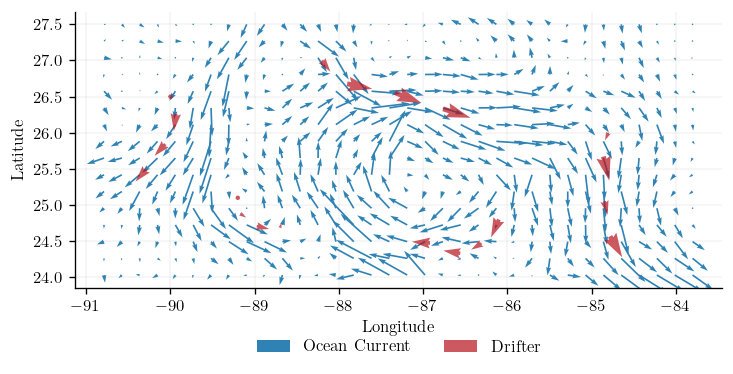

In [2]:
# function to place data from csv into correct array shape
def prepare_data(df):
    pos = jnp.array([df["lon"], df["lat"]])
    vel = jnp.array([df["ubar"], df["vbar"]])
    # extract shape stored as 'metadata' in the test data
    try:
        shape = (int(df["shape"][1]), int(df["shape"][0]))  # shape = (34,16)
        return pos, vel, shape
    except KeyError:
        return pos, vel


# loading in data

gulf_data_train = pd.read_csv(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/static/main/data/gulfdata_train.csv"
)
gulf_data_test = pd.read_csv(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/static/main/data/gulfdata_test.csv"
)


pos_test, vel_test, shape = prepare_data(gulf_data_test)
pos_train, vel_train = prepare_data(gulf_data_train)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.quiver(
    pos_test[0],
    pos_test[1],
    vel_test[0],
    vel_test[1],
    color=colors[0],
    label="Ocean Current",
    angles="xy",
    scale=10,
)
ax.quiver(
    pos_train[0],
    pos_train[1],
    vel_train[0],
    vel_train[1],
    color=colors[1],
    alpha=0.7,
    label="Drifter",
    angles="xy",
    scale=10,
)

ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
)
ax.legend(
    framealpha=0.0,
    ncols=2,
    fontsize="medium",
    bbox_to_anchor=(0.5, -0.3),
    loc="lower center",
)
plt.show()

## Problem Setting
We aim to obtain estimates for $\mathbf{F}$ at the set of points $\left\{ \mathbf{x}_{0,i} \right\}_{i=1}^N$ using Gaussian processes, followed by a comparison of the latent model to the ground truth $D_0$. Note that $D_0$ is not passed into any functions used  by GPJax, and is only used to compare against the two GP models at the end of the notebook.

Since $\mathbf{F}$ is a vector-valued function, we require GPs that can directly learn vector-valued functions[<sup>1</sup>](#fn1). To implement this in GPJax, the problem can be changed to learn a scalar-valued function by 'massaging' the data into a  $2N\times2N$ problem, such that each dimension of our GP is associated with a *component* of $\mathbf{y}_{T,i}$.

For a particular measurement $\mathbf{y}$ (training or testing) at location $\mathbf{x}$, the components $(y^{(0)}, y^{(1)})$ are described by the latent vector field $\mathbf{F}$, such that

$$
\mathbf{y} = \mathbf{F}(\mathbf{x}) = \left(\begin{array}{l}
f^{(0)}\left(\mathbf{x}\right) \\
f^{(1)}\left(\mathbf{x}\right)
\end{array}\right),
$$

where each $f^{(z)}\left(\mathbf{x}\right), z \in \{0,1\}$ is a scalar-valued function.

Now consider the scalar-valued function $g: \mathbb{R}^2 \times\{0,1\} \rightarrow \mathbb{R}$, such that

$$
g \left(\mathbf{x} , 0 \right) = f^{(0)} ( \mathbf{x} ), \text{and } g \left( \mathbf{x}, 1 \right)=f^{(1)}\left(\mathbf{x}\right).
$$

We have increased the input dimension by 1, from the 2D $\mathbf{x}$ to the 3D $\mathbf{X} = \left(\mathbf{x}, 0\right)$ or $\mathbf{X} = \left(\mathbf{x}, 1\right)$.

By choosing the value of the third dimension, 0 or 1, we may now incorporate this
information into the computation of the kernel.
We therefore make new 3D datasets $D_{T,3D} = \left\{\left( \mathbf{X}_{T,i},\mathbf{Y}_{T,i} \right) \right\} _{i=0}^{2N_T}$ and $D_{0,3D} = \left\{\left( \mathbf{X}_{0,i},\mathbf{Y}_{0,i} \right) \right\} _{i=0}^{2N}$ that incorporates this new labelling, such that for each dataset (indicated by the subscript $D = 0$ or $D=T$),

$$
X_{D,i} = \left( \mathbf{x}_{D,i}, z \right),
$$
and
$$
Y_{D,i} = y_{D,i}^{(z)},
$$

where $z = 0$ if $i$ is odd and $z=1$ if $i$ is even.

In [3]:
# Change vectors x -> X = (x,z), and vectors y -> Y = (y,z) via the artificial z label
def label_position(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T


# change vectors y -> Y by reshaping the velocity measurements
def stack_velocity(data):
    return data.T.flatten().reshape(-1, 1)


def dataset_3d(pos, vel):
    return gpx.Dataset(label_position(pos), stack_velocity(vel))


# label and place the training data into a Dataset object to be used by GPJax
dataset_train = dataset_3d(pos_train, vel_train)

# we also require the testing data to be relabelled for later use, such that we can query the 2Nx2N GP at the test points
dataset_ground_truth = dataset_3d(pos_test, vel_test)

## Velocity (dimension) decomposition
Having labelled the data, we are now in a position to use GPJax to learn the function $g$, and hence $\mathbf{F}$. A naive approach to the problem is to apply a GP prior directly to the velocities of each dimension independently, which is called the *velocity* GP. For our prior, we choose an isotropic mean 0 over all dimensions of the GP, and a piecewise kernel that depends on the $z$ labels of the inputs, such that for two inputs $\mathbf{X} = \left( \mathbf{x}, z \right )$ and $\mathbf{X}^\prime = \left( \mathbf{x}^\prime, z^\prime \right )$,

$$
k_{\text{vel}} \left(\mathbf{X}, \mathbf{X}^{\prime}\right)=
\begin{cases}k^{(z)}\left(\mathbf{x}, \mathbf{x}^{\prime}\right) & \text { if }
z=z^{\prime} \\ 0 & \text { if } z \neq z^{\prime}, \end{cases}
$$

where $k^{(z)}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)$ are the user chosen kernels for each dimension. What this means is that there are no correlations between the $x^{(0)}$ and $x^{(1)}$ dimensions for all choices $\mathbf{X}$ and $\mathbf{X}^{\prime}$, since there are no off-diagonal elements in the Gram matrix populated by this choice.

To implement this approach in GPJax, we define `VelocityKernel` in the following cell, following the steps outlined in the [custom kernels notebook](https://docs.jaxgaussianprocesses.com/examples/constructing_new_kernels/#custom-kernel). This modular implementation takes the choice of user kernels as its class attributes: `kernel0` and `kernel1`. We must additionally pass the argument `active_dims = [0,1]`, which is an attribute of the base class `AbstractKernel`, into the chosen kernels. This is necessary such that the subsequent likelihood optimisation does not optimise over the artificial label dimension.


In [4]:
@dataclass
class VelocityKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0

        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)

### GPJax implementation
Next, we define the model in GPJax. The prior is defined using $k_{\text{vel}}\left(\mathbf{X}, \mathbf{X}^\prime \right)$ and 0 mean and 0 observation noise. We choose a Gaussian marginal log-likelihood (MLL).


In [5]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.Gaussian(
        num_datapoints=dataset.n, obs_noise=jnp.array([1.0e-6], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior


# Define the velocity GP
mean = gpx.mean_functions.Zero()
kernel = VelocityKernel()
velocity_posterior = initialise_gp(kernel, mean, dataset_train)

With a model now defined, we can proceed to optimise the hyperparameters of our likelihood over $D_0$. This is done by minimising the MLL using `jaxopt`. We also plot its value at each step to visually confirm that we have found the minimum. See the  [introduction to Gaussian Processes](https://docs.jaxgaussianprocesses.com/examples/intro_to_gps/) notebook for more information on optimising the MLL.

  0%|          | 0/100 [00:00<?, ?it/s]

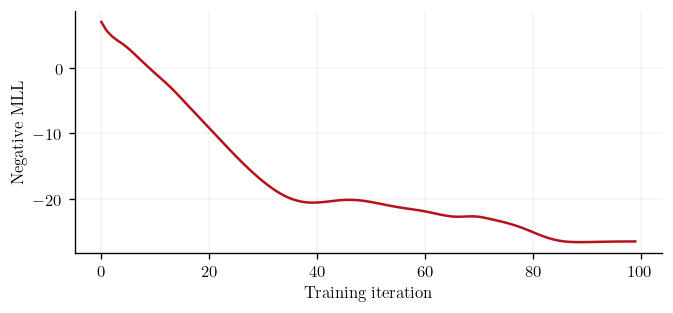

In [6]:
def optimise_mll(posterior, dataset, NIters=100, key=key, plot_history=True):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit(
        model=posterior,
        train_data=dataset,
        solver = jaxopt.OptaxSolver(gpx.ConjugateMLL(negative=True), opt=ox.adam(1e-1), maxiter=NIters),
        #solver=jaxopt.LBFGS(gpx.ConjugateMLL(negative=True), maxiter=NIters),
        safe=True,
        key=key,
    )
    # plot MLL value at each iteration
    if plot_history:
        fig, ax = plt.subplots(1, 1)
        ax.plot(history, color=colors[1])
        ax.set(xlabel="Training iteration", ylabel="Negative MLL")

    return opt_posterior


opt_velocity_posterior = optimise_mll(velocity_posterior, dataset_train)

### Comparison
We next obtain the latent distribution of the GP of $g$ at $\mathbf{x}_{0,i}$, then extract its mean and standard at the test locations, $\mathbf{F}_{\text{latent}}(\mathbf{x}_{0,i})$, as well as the standard deviation (we will use it at the very end).

In [7]:
def latent_distribution(opt_posterior, pos_3d, dataset_train):
    latent = opt_posterior.predict(pos_3d, train_data=dataset_train)
    latent_mean = latent.mean()
    latent_std = latent.stddev()
    return latent_mean, latent_std


# extract latent mean and std of g, redistribute into vectors to model F
velocity_mean, velocity_std = latent_distribution(
    opt_velocity_posterior, dataset_ground_truth.X, dataset_train
)

dataset_latent_velocity = dataset_3d(pos_test, velocity_mean)

We now replot the ground truth (testing data) $D_0$, the predicted latent vector field $\mathbf{F}_{\text{latent}}(\mathbf{x_i})$, and a heatmap of the residuals at each location $\mathbf{R}(\mathbf{x}_{0,i}) = \mathbf{y}_{0,i} - \mathbf{F}_{\text{latent}}(\mathbf{x}_{0,i}) $, as well as $\left|\left|\mathbf{R}(\mathbf{x}_{0,i})\right|\right|$.

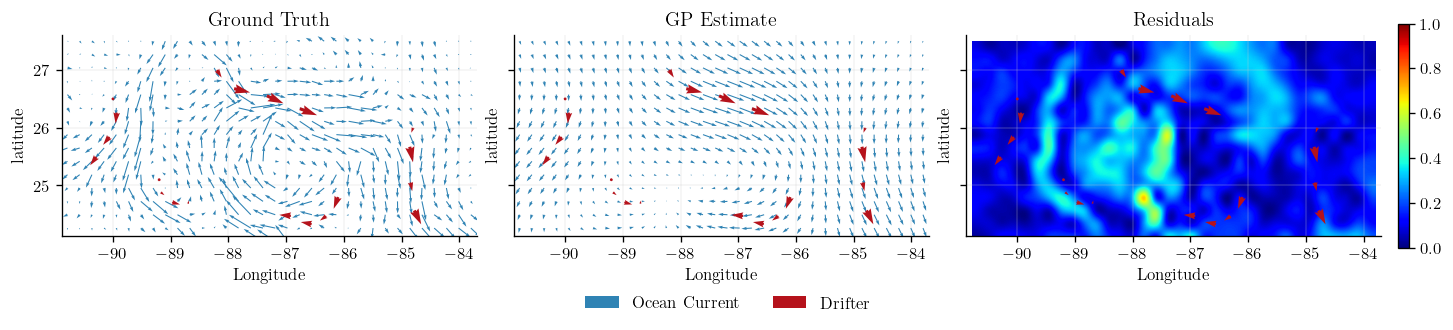

In [8]:
# Residuals between ground truth and estimate


def plot_vector_field(ax, dataset, **kwargs):
    ax.quiver(
        dataset.X[::2][:, 0],
        dataset.X[::2][:, 1],
        dataset.y[::2],
        dataset.y[1::2],
        **kwargs,
    )


def prepare_ax(ax, X, Y, title, **kwargs):
    ax.set(
        xlim=[X.min() - 0.1, X.max() + 0.1],
        ylim=[Y.min() + 0.1, Y.max() + 0.1],
        aspect="equal",
        title=title,
        ylabel="latitude",
        **kwargs,
    )


def residuals(dataset_latent, dataset_ground_truth):
    return jnp.sqrt(
        (dataset_latent.y[::2] - dataset_ground_truth.y[::2]) ** 2
        + (dataset_latent.y[1::2] - dataset_ground_truth.y[1::2]) ** 2
    )


def plot_fields(
    dataset_ground_truth, dataset_trajectory, dataset_latent, shape=shape, scale=10
):
    X = dataset_ground_truth.X[:, 0][::2]
    Y = dataset_ground_truth.X[:, 1][::2]
    # make figure
    fig, ax = plt.subplots(1, 3, figsize=(12.0, 3.0), sharey=True)

    # ground truth
    plot_vector_field(
        ax[0],
        dataset_ground_truth,
        color=colors[0],
        label="Ocean Current",
        angles="xy",
        scale=scale,
    )
    plot_vector_field(
        ax[0],
        dataset_trajectory,
        color=colors[1],
        label="Drifter",
        angles="xy",
        scale=scale,
    )
    prepare_ax(ax[0], X, Y, "Ground Truth", xlabel="Longitude")

    # Latent estimate of vector field F
    plot_vector_field(ax[1], dataset_latent, color=colors[0], angles="xy", scale=scale)
    plot_vector_field(
        ax[1], dataset_trajectory, color=colors[1], angles="xy", scale=scale
    )
    prepare_ax(ax[1], X, Y, "GP Estimate", xlabel="Longitude")

    # residuals
    residuals_vel = jnp.flip(
        residuals(dataset_latent, dataset_ground_truth).reshape(shape), axis=0
    )
    im = ax[2].imshow(
        residuals_vel,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        cmap="jet",
        vmin=0,
        vmax=1.0,
        interpolation="spline36",
    )
    plot_vector_field(
        ax[2], dataset_trajectory, color=colors[1], angles="xy", scale=scale
    )
    prepare_ax(ax[2], X, Y, "Residuals", xlabel="Longitude")
    fig.colorbar(im, fraction=0.027, pad=0.04, orientation="vertical")

    fig.legend(
        framealpha=0.0,
        ncols=2,
        fontsize="medium",
        bbox_to_anchor=(0.5, -0.03),
        loc="lower center",
    )
    plt.show()


plot_fields(dataset_ground_truth, dataset_train, dataset_latent_velocity)

From the latent estimate we can see the velocity GP struggles to reconstruct features of the ground truth. This is because our construction of the kernel placed an independent prior on each physical dimension, which cannot be assumed. Therefore, we need a different approach that can implicitly incorporate this dependence at a fundamental level. To achieve this we will require a *Helmholtz Decomposition*.

## Helmholtz decomposition
In 2 dimensions, a twice continuously differentiable and compactly supported vector field $\mathbf{F}: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ can be expressed as the sum of the gradient of a scalar potential $\Phi: \mathbb{R}^2 \rightarrow \mathbb{R}$, called the potential function, and the vorticity operator of another scalar potential $\Psi: \mathbb{R}^2 \rightarrow \mathbb{R}$, called the stream function ([Berlinghieri et al. (2023)](https://arxiv.org/pdf/2302.10364.pdf)) such that
$$
\mathbf{F}=\operatorname{grad} \Phi+\operatorname{rot} \Psi,
$$
where
$$
\operatorname{grad} \Phi:=\left[\begin{array}{l}
\partial \Phi / \partial x^{(0)} \\
\partial \Phi / \partial x^{(1)}
\end{array}\right] \text { and } \operatorname{rot} \Psi:=\left[\begin{array}{c}
\partial \Psi / \partial x^{(1)} \\
-\partial \Psi / \partial x^{(0)}
\end{array}\right].
$$

This is reminiscent of a 3 dimensional [Helmholtz decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition).

The 2 dimensional decomposition motivates a different approach: placing priors on $\Psi$ and $\Phi$, allowing us to make assumptions directly about fundamental properties of $\mathbf{F}$. If we choose independent GP priors such that $\Phi \sim \mathcal{G P}\left(0, k_{\Phi}\right)$ and $\Psi \sim \mathcal{G P}\left(0, k_{\Psi}\right)$, then $\mathbf{F} \sim \mathcal{G P} \left(0, k_\text{Helm}\right)$ (since acting linear operations on a GPs give GPs).

For $\mathbf{X}, \mathbf{X}^{\prime} \in \mathbb{R}^2 \times \left\{0,1\right\}$ and $z, z^\prime \in \{0,1\}$,

$$
\boxed{ k_{\mathrm{Helm}}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)_{z,z^\prime} =  \frac{\partial^2 k_{\Phi}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)}{\partial x^{(z)} \partial\left(x^{\prime}\right)^{(z^\prime)}}+(-1)^{z+z^\prime} \frac{\partial^2 k_{\Psi}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)}{\partial x^{(1-z)} \partial\left(x^{\prime}\right)^{(1-z^\prime)}}}.
$$

where $x^{(z)}$ and $(x^\prime)^{(z^\prime)}$ are the $z$ and $z^\prime$ components of $\mathbf{X}$ and ${\mathbf{X}}^{\prime}$ respectively.

We compute the second derivatives using `jax.hessian`. In the following implementation, for a kernel $k(\mathbf{x}, \mathbf{x}^{\prime})$, this computes the Hessian matrix with respect to the components of $\mathbf{x}$

$$
\frac{\partial^2 k\left(\mathbf{x}, \mathbf{x}^{\prime}\right)}{\partial x^{(z)} \partial x^{(z^\prime)}}.
$$

Note that we have operated $\dfrac{\partial}{\partial x^{(z)}}$, *not* $\dfrac{\partial}{\partial \left(x^\prime \right)^{(z)}}$, as the boxed equation suggests. This is not an issue if we choose stationary kernels $k(\mathbf{x}, \mathbf{x}^{\prime}) = k(\mathbf{x} - \mathbf{x}^{\prime})$ , as the partial derivatives with respect to the components have the following exchange symmetry:

$$
\frac{\partial}{\partial x^{(z)}} = - \frac{\partial}{\partial \left( x^\prime \right)^{(z)}},
$$

for either $z$.

In [9]:
@dataclass
class HelmholtzKernel(gpx.kernels.AbstractKernel):
    # initialise Phi and Psi kernels as any stationary kernel in gpJax
    potential_kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1], variance=jnp.array(0.00001))
    stream_kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # obtain indices for k_helm, implement in the correct sign between the derivatives
        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)
        sign = (-1) ** (z + zp)

        # convert to array to correctly index, -ve sign due to exchange symmetry (only true for stationary kernels)
        potential_dvtve = -jnp.array(
            hessian(self.potential_kernel)(X, Xp), dtype=jnp.float64
        )[z][zp]
        stream_dvtve = -jnp.array(
            hessian(self.stream_kernel)(X, Xp), dtype=jnp.float64
        )[1 - z][1 - zp]

        return potential_dvtve + sign * stream_dvtve

### GPJax implementation
We repeat the same steps as with the velocity GP model, replacing `VelocityKernel` with `HelmholtzKernel`.

  0%|          | 0/100 [00:00<?, ?it/s]

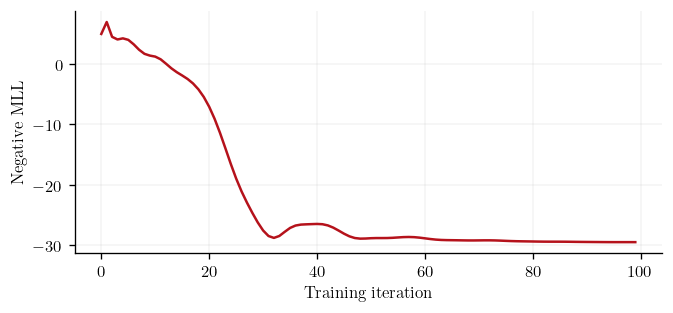

In [10]:
# Redefine Gaussian process with Helmholtz kernel
kernel = HelmholtzKernel()
helmholtz_posterior = initialise_gp(kernel, mean, dataset_train)
# Optimise hyperparameters using optax
opt_helmholtz_posterior = optimise_mll(helmholtz_posterior, dataset_train)

### Comparison
We again plot the ground truth (testing data) $D_0$, the predicted latent vector field $\mathbf{F}_{\text{latent}}(\mathbf{x}_{0,i})$, and a heatmap of the residuals at each location $R(\mathbf{x}_{0,i}) = \mathbf{y}_{0,i} - \mathbf{F}_{\text{latent}}(\mathbf{x}_{0,i})$ and $\left|\left|R(\mathbf{x}_{0,i})  \right|\right|$.

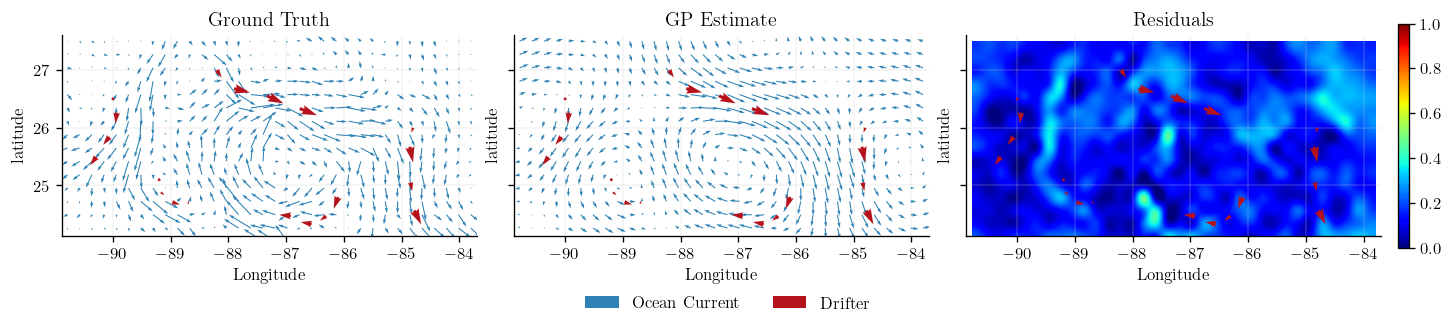

In [11]:
# obtain latent distribution, extract x and y values over g
helmholtz_mean, helmholtz_std = latent_distribution(
    opt_helmholtz_posterior, dataset_ground_truth.X, dataset_train
)
dataset_latent_helmholtz = dataset_3d(pos_test, helmholtz_mean)

plot_fields(dataset_ground_truth, dataset_train, dataset_latent_helmholtz)

Visually, the Helmholtz model performs better than the velocity model, preserving the local structure of the $\mathbf{F}$. Since we placed priors on $\Phi$ and $\Psi$, the construction of $\mathbf{F}$ allows for correlations between the dimensions (non-zero off-diagonal elements in the Gram matrix populated by $k_\text{Helm}\left(\mathbf{X},\mathbf{X}^{\prime}\right)$ ).

## Negative log predictive densities
Lastly, we directly compare the velocity and Helmholtz models by computing the [negative log predictive densities](https://en.wikipedia.org/wiki/Negative_log_predictive_density) for each model. This is a quantitative metric that measures the probability of the ground truth given the data.

$$
\mathrm{NLPD}=-\sum_{i=1}^{2N} \log \left(  p\left(\mathcal{Y}_i = Y_{0,i} \mid \mathbf{X}_{i}\right) \right),
$$

where each $p\left(\mathcal{Y}_i \mid \mathbf{X}_i \right)$ is the marginal Gaussian distribution over $\mathcal{Y}_i$ at each test location, and $Y_{i,0}$ is the $i$-th component of the (massaged) test data that we reserved at the beginning of the notebook in $D_0$. A smaller value is better, since the deviation of the ground truth and the model are small in this case.

In [12]:
# ensure testing data alternates between x0 and x1 components
def nlpd(mean, std, vel_test):
    vel_query = jnp.column_stack((vel_test[0], vel_test[1])).flatten()
    normal = tfp.substrates.jax.distributions.Normal(loc=mean, scale=std)
    return -jnp.sum(normal.log_prob(vel_query))


# compute nlpd for velocity and helmholtz
nlpd_vel = nlpd(velocity_mean, velocity_std, vel_test)
nlpd_helm = nlpd(helmholtz_mean, helmholtz_std, vel_test)

print("NLPD for Velocity: %.2f \nNLPD for Helmholtz: %.2f" % (nlpd_vel, nlpd_helm))

NLPD for Velocity: 1566.11 
NLPD for Helmholtz: -208.06


The Helmholtz model outperforms the velocity model, as indicated by the lower NLPD score.

<span id="fn1"></span>
## Footnote
Kernels for vector-valued functions have been studied in the literature, see [Alvarez et al. (2012)](https://doi.org/10.48550/arXiv.1106.6251)
## System configuration

In [13]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Ivan Shalashilin'

Author: Ivan Shalashilin

Last updated: Tue Sep 19 2023

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.12.2

jax                   : 0.4.9
gpjax                 : 0.0.0
tensorflow_probability: 0.19.0
pandas                : 1.5.3
jaxopt                : 0.6
matplotlib            : 3.7.1
optax                 : 0.1.5

Watermark: 2.3.1

